<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Spline-fitting-with-Genetic-Algorithm" data-toc-modified-id="Spline-fitting-with-Genetic-Algorithm-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Spline fitting with Genetic Algorithm</a></span><ul class="toc-item"><li><span><a href="#Selection" data-toc-modified-id="Selection-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Selection</a></span></li><li><span><a href="#Crossover-and-Mutation" data-toc-modified-id="Crossover-and-Mutation-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Crossover and Mutation</a></span></li><li><span><a href="#The-procedure" data-toc-modified-id="The-procedure-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>The procedure</a></span></li></ul></li><li><span><a href="#TimeOpt-v2" data-toc-modified-id="TimeOpt-v2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>TimeOpt v2</a></span><ul class="toc-item"><li><span><a href="#Selection" data-toc-modified-id="Selection-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Selection</a></span></li><li><span><a href="#crossover-and-mutation" data-toc-modified-id="crossover-and-mutation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>crossover and mutation</a></span></li><li><span><a href="#The-procedure" data-toc-modified-id="The-procedure-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>The procedure</a></span></li><li><span><a href="#Misc" data-toc-modified-id="Misc-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Misc</a></span></li></ul></li><li><span><a href="#TimeOpt-v3" data-toc-modified-id="TimeOpt-v3-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>TimeOpt v3</a></span><ul class="toc-item"><li><span><a href="#Play-Ground" data-toc-modified-id="Play-Ground-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Play Ground</a></span></li><li><span><a href="#Selection-and-metric" data-toc-modified-id="Selection-and-metric-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Selection and metric</a></span></li><li><span><a href="#Crossover-and-Mutation" data-toc-modified-id="Crossover-and-Mutation-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Crossover and Mutation</a></span></li><li><span><a href="#The-Procedure" data-toc-modified-id="The-Procedure-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>The Procedure</a></span></li></ul></li><li><span><a href="#eTimeOpt" data-toc-modified-id="eTimeOpt-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>eTimeOpt</a></span></li></ul></div>

In [4196]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splev, splrep, LSQUnivariateSpline, PchipInterpolator
from scipy.integrate import simps
from sklearn.linear_model import LinearRegression
from functools import partial
from random import shuffle
import scipy as sp

## Spline fitting with Genetic Algorithm

Based on Yoshimoto et al. 2003 \
https://www.sciencedirect.com/science/article/pii/S001044850300006X

(-20.0, 110.0)

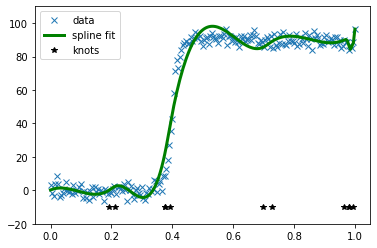

In [1090]:
x_data = np.arange(0,1.+1e-8,0.005)
N = len(x_data)
def f_Ex1 (x):
    return 90/(1+np.exp(-100*(x-0.4)))
def f_Ex2 (x):
    return np.concatenate([1/(0.01 + (x[x<0.6]-0.3)**2), 1/(0.015 + (x[x>=0.6]-0.65)**2) ],axis=0) 

y_data = f_Ex1(x_data) + np.random.randn(N)*3
# y_data = f_Ex2(x_data) + np.random.randn(N)

# plt.plot(x_data, y_data,'x')
# knots = np.array([0.1, 0.3,0.6,0.7,0.9])
knots = np.array([0.19334084, 0.2125511 , 0.37671083, 0.37756784, 0.39349249,0.69963719, 0.72624378, 0.96566566, 0.97987222, 0.9819273, 0.99267495])
knots = knots[1:]
#         0.99267495])

knots = np.array([0.19334084, 0.2125511 , 0.37671083, 0.37756784, 0.39349249,
        0.69963719, 0.72624378, 0.96566566, 0.97987222, 0.9819273 ,
        0.99267495])
m = 3 #cubic spline
spl = LSQUnivariateSpline(x_data, y_data, knots, k=m)
plt.plot(x_data, y_data,'x', label="data")
plt.plot(x_data, spl(x_data), 'g-', lw=3, label="spline fit")
plt.plot(knots, knots*0-10, "*", c="black", label="knots")
plt.legend()
plt.ylim([-20, 110])
# x_data

### Selection

In [73]:
Q  =  np.sum((y_data - spl(x_data))**2 )
n = len(knots)
BIC = N*np.log(Q) + np.log(N)*(2*n+m)

(909.7886352397177, 59.867212417845195)

In [3336]:
def selection_tournament(fits, n, k=2, elitism=True):
    """
    input: fits - the fitness of the populations
           k - size of the tournament, default is 2
           n - size of the selected individuals
    randomly select k candidates for the tournaments, pick the best
    repeat n times
    output: indexes of n selected individuals by the tournament
    """
    inds = np.arange(len(fits))
    inds_tnm = np.random.choice(inds, (n,k))
    winner_results = np.argmax(fits[inds_tnm], 1)
    inds_winner =np.choose(winner_results, inds_tnm.T)
    if elitism:
        arg_best = np.argmax(fits)
        if arg_best not in inds_winner:
            inds_winner[np.random.choice(n)] = arg_best
    return inds_winner
# selection_tournament(np.linspace(0,1,11), 10)

### Crossover and Mutation

In [230]:
def crossover(x1, x2, interval=None, range_data=[0,1]):
    """ crossover operation
    input: x1 (n,), x2 (m,) in ascending order
    given / define randomly an interval in range_data 
    swap all the array elements inside the interval of x1 with x2
    return (x1_x, x2_x)
    """
    if interval is None:
        interval = np.sort(np.random.rand(2))*(range_data[1]-range_data[0]) + range_data[0]          
    arg_range1 = np.searchsorted(x1, interval)
    arg_range2 = np.searchsorted(x2, interval)
    x1_x = np.hstack([x1[:arg_range1[0]], x2[arg_range2[0]:arg_range2[1]], x1[arg_range1[1]:]] )
    x2_x = np.hstack([x2[:arg_range2[0]], x1[arg_range1[0]:arg_range1[1]], x2[arg_range2[1]:]] )
    return [x1_x, x2_x]
# TEST
# x1 = np.linspace(0,10,11)
# x2 = np.linspace(4,7,4)+0.5
# a, b= crossover(x1,x2, None, [0,10])
# len(a)+len(b) == len(x1)+len(x2), np.sum(np.diff(a)<0), np.sum(np.diff(b)<0)

In [353]:
def mutation(x1, pm, range_data=[0,1]):
    """
    input: x1(n,) is a gene
    pm is probability of mutaion
    cycle through each element of x1: for each iteration delete it (50%) or 
    randomly create a new element (50%) with a probability pm
    output: new x1
    """
    x1_m = x1.copy()
    n = len(x1)
    bool_m = np.random.rand(n) < pm
    arg_m  = np.argwhere(bool_m)
    bool_del = np.random.rand(len(arg_m)) < 0.5
    arg_del = arg_m[bool_del]
    new_ele = np.random.rand(len(arg_m)-len(arg_del))*(range_data[1] - range_data[0]) + range_data[0]
    x1_m = np.delete(x1_m, arg_del)
    x1_m = np.sort(np.hstack([x1_m, new_ele]))
    return x1_m
# TEST 
# v = np.zeros(1000)
# for i in range(1000):
#     v[i] = len(mutation(np.linspace(0,1,100), 0.5))
# v.mean()

100.096

### The procedure

Generating the initial population

In [1091]:
L = 10 # Initial number of interior knots
K = 200 # number of individual in population 
n_generation = 100
knots_ini = np.sort(np.random.rand(K,L), axis=1)
knots_ini = knots_ini*(x_data[-1]-x_data[1])+x_data[1]
m = 3
# spl = LSQUnivariateSpline(x_data, y_data, knots, k=m)
# spls = [LSQUnivariateSpline(x_data, y_data, knots, k=m) for knots in knots_ini]
# len_knots = np.array([len(knots) for knots in knots_ini])
BICs_all = np.zeros((n_generation-1,K))
knots_all = [" "]*n_generation
knots_all[0] = knots_ini

In [1092]:
def zero_function(x):
    return x*0
def BIC_pop(knots_pop, x_data, y_data, m):
    spls = []
    for i in range(len(knots_pop)):
        try:
            spl = LSQUnivariateSpline(x_data, y_data, knots_pop[i], k=m, bbox=(0,1))
        except:
#             print("error")
            spl = zero_function
        spls += [spl]
#     spls = [LSQUnivariateSpline(x_data, y_data, knots, k=m, bbox=(0,1)) for knots in knots_pop]
    len_knots = np.array([len(knots) for knots in knots_pop])
    Qs  =  np.array([np.sum((y_data - spl(x_data))**2 ) for spl in spls])
    N = len(y_data)
    BICs = N*np.log(Qs) + np.log(N)*(2*len_knots+m+1)
    return BICs
# Qs  =  np.array([np.sum((y_data - spl(x_data))**2 ) for spl in spls])
# # n = len(knots)
# BICs = N*np.log(Qs) + np.log(N)*(2*len_knots+m)


In [1095]:
for i in range(n_generation-1):
    knots_old = knots_all[i]
    BICs = BIC_pop(knots_old, x_data, y_data, m)
    BICs_all[i] = BICs
    selected_inds = selection_tournament(-BICs, K)
    BICs = BICs[selected_inds]
    BICmean = BICs.mean(); BICmin = BICs.min()
    knots_new = []
    for j in range(0,K,2):
        BICm = np.min(BICs[j:j+2])
        pc = (BICm-BICmin)/(BICmean-BICmin) if BICm <= BICmean else 1
        if np.random.rand() < pc:
            knots_new  += crossover(knots_old[selected_inds[j]], knots_old[selected_inds[j+1]])
        else:
            knots_new += [knots_old[selected_inds[j]], knots_old[selected_inds[j+1]]]
    BICs = BIC_pop(knots_new, x_data, y_data, m)
    BICmean = BICs.mean(); BICmin = BICs.min()
    for j in range(K):
        pm = 0.5*(BICs[j]-BICmin)/(BICmean-BICmin) if BICs[j] <= BICmean else 0.5
        knots_new[j] = mutation(knots_new[j], pm)
    knots_all[i+1] = knots_new

/tmp/ipykernel_1212742/2240026594.py:11: RuntimeWarning: invalid value encountered in double_scalars
  pc = (BICm-BICmin)/(BICmean-BICmin) if BICm <= BICmean else 1
/tmp/ipykernel_1212742/2240026594.py:19: RuntimeWarning: invalid value encountered in double_scalars
  pm = 0.5*(BICs[j]-BICmin)/(BICmean-BICmin) if BICs[j] <= BICmean else 0.5


Best solution

Example 1

Text(0, 0.5, 'BIC')

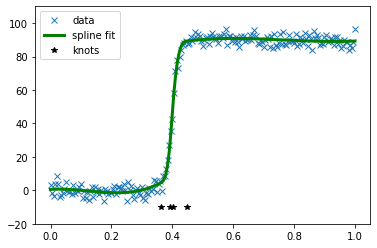

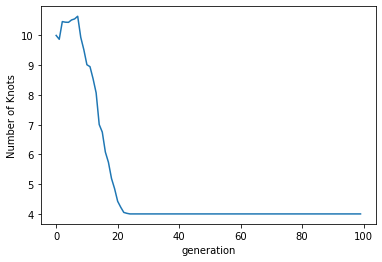

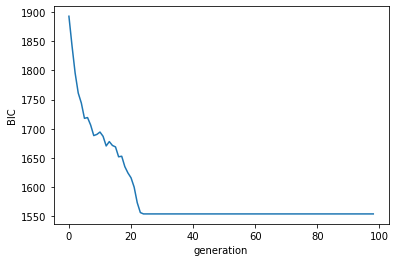

In [1097]:
arg_best = np.argmin(BICs_all[-1])
knots = knots_all[-1][arg_best]
m = 3 #cubic spline
spl = LSQUnivariateSpline(x_data, y_data, knots, k=m)
# fig, axs = plt.subplots(3, 1)
plt.figure()
# plt = axs[0]
plt.plot(x_data, y_data,'x', label="data")
plt.plot(x_data, spl(x_data), 'g-', lw=3, label="spline fit")
plt.plot(knots, knots*0-10, "*", c="black", label="knots")
plt.legend()
plt.ylim([-20, 110])

plt.figure()
len_knots = np.array([[len(knots_all[j][i]) for i in range(K) ] for j in range(n_generation)  ])
plt.plot(len_knots.mean(axis=1))
plt.xlabel("generation")
plt.ylabel("Number of Knots")

plt.figure()
# for i in range(n_generation):
#     BICs_all[i] = BIC_pop(knots_all[i], x_data, y_data, m)
plt.plot(BICs_all.mean(axis=1))
plt.xlabel("generation")
plt.ylabel("BIC")
# plt.ylim([1000,2000])

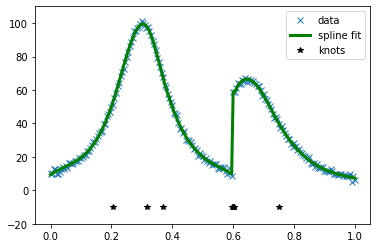

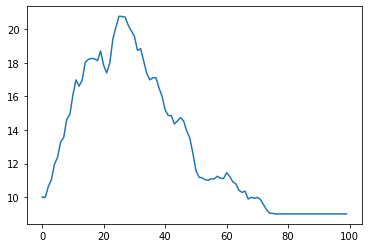

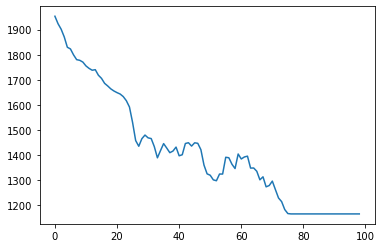

In [1089]:
arg_best = np.argmin(BICs_all[-1])
knots = knots_all[-1][arg_best]
m = 3 #cubic spline
spl = LSQUnivariateSpline(x_data, y_data, knots, k=m)
# fig, axs = plt.subplots(3, 1)
plt.figure()
# plt = axs[0]
plt.plot(x_data, y_data,'x', label="data")
plt.plot(x_data, spl(x_data), 'g-', lw=3, label="spline fit")
plt.plot(knots, knots*0-10, "*", c="black", label="knots")
plt.legend()
plt.ylim([-20, 110])

plt.figure()
len_knots = np.array([[len(knots_all[j][i]) for i in range(K) ] for j in range(n_generation)  ])
plt.plot(len_knots.mean(axis=1))

plt.figure()
# for i in range(n_generation):
#     BICs_all[i] = BIC_pop(knots_all[i], x_data, y_data, m)
plt.plot(BICs_all.mean(axis=1))
# plt.ylim([1000,2000])

## TimeOpt v2

In [1218]:
x = np.linspace(0, 1, 10)
x = np.array([0, 1, 4, 5, 8,  10])
y = x*10 + np.sin(x)*7 + 100
spl = splrep(x, y)
x2 = np.linspace(0, 10, 200)
y2 = splev(x2, spl)
ytrue = x2*10 + np.sin(x2)*7 + 100
plt.plot(x, y, 'o', x2, y2)
plt.plot(x2, ytrue, '--')
# plt.show()

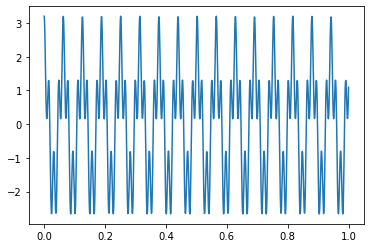

In [1727]:
N = 1000
d = np.linspace(0, 1, N)
# t = d*10 + np.sin(d)*7 + 100
t = d*100
f1 = 1; f2=4
A1 = 2; A2 = 1.2
# phi1 = 1; phi2=0.2
y = A1*np.cos(f1*t) + A2*np.cos(f2*t) 
eps = np.random.randn(N)
y_data = y + eps*0.0
plt.plot(d,y_data)
# plt.plot(t,d)

In [1563]:
x1 = np.cos(f1*t)
x2 = np.cos(f2*t)
X = np.vstack([x1,x2]).T
# X.shape
reg = LinearRegression().fit(X, y_data)
reg.score(X, y_data), reg.coef_, reg.intercept_

(0.9961224010802322, array([2.00589061, 0.9958055 ]), 0.00314168044327389)

### Selection

(0.0, 100.0)

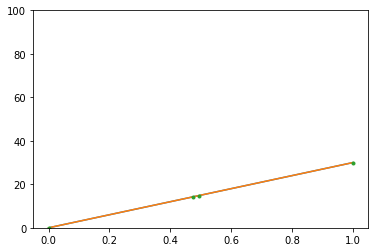

In [1807]:
%matplotlib inline
N_genes = 4
depth_grid = np.linspace(0,1,1000)
depth = np.concatenate([np.random.rand(N_genes-2), np.array([0,1])])
time = np.random.rand(N_genes)*100
time.sort(); depth.sort()
time = depth*30
td = np.vstack([depth,time])
spl = splrep(depth, time, s=12)
y1 = splev(depth_grid, spl)
spl2 = PchipInterpolator(depth, time)
y2 = spl2(depth_grid)
plt.plot(depth_grid, y1, depth_grid, y2, depth, time, ".")
plt.ylim([0,100])

-0.007552200664293185 [0.00893025 0.09183925] -0.010715681765166121


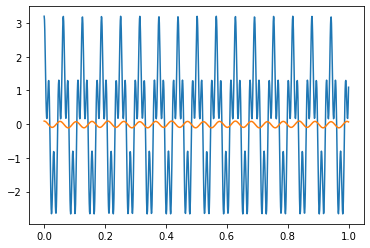

In [1810]:
spl2 = PchipInterpolator(depth, time)
t = spl2(depth_data)
# t = 100*d
x1 = np.cos(f1*t);
x2 = np.cos(f2*t)
Xmodel = np.vstack([x1,x2]).T
# X.shape
reg = LinearRegression().fit(Xmodel, y_data)
# reg.score(X, y_data), reg.coef_, reg.intercept_
plt.plot(d, y_data)
plt.plot(d, reg.predict(Xmodel))
print(reg.score(X, y_data), reg.coef_, reg.intercept_)

In [2092]:
def zero_function(x):
    return x*0

def BIC(td, depth, data, fs):
    spl = PchipInterpolator(td[0], td[1])
    t = spl(depth)
    Xmodel = np.cos(np.array(fs)[None]*t[:,None])
    reg_model = LinearRegression().fit(Xmodel, data)
    # Residual Sum Square
    RSS = np.sum((data - reg_model.predict(Xmodel))**2 )
    N = len(data)
    n_params_td = len(td[0])*0
    BIC = N*np.log(RSS) + np.log(N)*(n_params_td*2 + len(fs)+1)
    return BIC
    
def BIC_pop(tds, depth, data, fs):
    return np.array([BIC(td, depth, data,fs) for td in tds]) 
BIC(td, d, y_data, [f1,f2])

7179.006764784674

### crossover and mutation

In [3446]:
def crossover_curve(X1, X2, x_dis=0.5, xrange=[0,1]):
    """
    input: X1(2,n), X2(2,m) - 2 set of 2d-points defining 2 curves
    randomly pick X1 or X2 with probability of 50%
    randomly pick a point x in X1/X2 with a tringular distribution to
    prioritize the middle part as a point of disconnection
    Form 2 children from X1, X2 that disconnects at x and inherit from both
    parents
    output: 2 children
    """
    X = X1 if np.random.rand() < 0.5 else X2
    X = X1
    if x_dis is None:
        x_dis = np.random.triangular(xrange[0], (xrange[0]+xrange[1])/2, xrange[1])
    ind_dis = np.searchsorted(X[0], x_dis)
    # INTERPOLATION
    y_dis = (X[1,ind_dis]-X[1,ind_dis-1])/(X[0,ind_dis]-X[0,ind_dis-1])*(x_dis-X[0,ind_dis-1]) + X[1,ind_dis-1]
    ind_dis_X1 = np.sort([np.searchsorted(X1[0], x_dis), np.searchsorted(X1[1], y_dis)])
    ind_dis_X2 = np.sort([np.searchsorted(X2[0], x_dis), np.searchsorted(X2[1], y_dis)])
    X1_child = np.hstack([X1[:,:ind_dis_X1[0]], X2[:,ind_dis_X2[1]:]] )
    X2_child = np.hstack([X2[:,:ind_dis_X2[0]], X1[:,ind_dis_X1[1]:]] )
    return X1_child, X2_child
def crossover_curve_v2(X1, X2, y_dis=None):
    """
    v2: almost similar to v1
    """
    X = X1 if np.random.rand() < 0.5 else X2
    yrange = [np.max([X1[1,0], X2[1,0] ] ), np.min([X1[1,-1], X2[1,-1] ] )]
    if yrange[0] > yrange[1]:
        return X1, X2
    if y_dis is None:
        y_dis = np.random.triangular(yrange[0], (yrange[0]+yrange[1])/2, yrange[1])
    ind_dis = np.searchsorted(X[1], y_dis)
    # INTERPOLATION
    x_dis = (X[0,ind_dis]-X[0,ind_dis-1])/(X[1,ind_dis]-X[1,ind_dis-1])*(y_dis-X[1,ind_dis-1]) + X[0,ind_dis-1]
    ind_dis_X1 = np.sort([np.searchsorted(X1[0], x_dis), np.searchsorted(X1[1], y_dis)])
    ind_dis_X2 = np.sort([np.searchsorted(X2[0], x_dis), np.searchsorted(X2[1], y_dis)])
    X1_child = np.hstack([X1[:,:ind_dis_X1[0]], X2[:,ind_dis_X2[1]:]] )
    X2_child = np.hstack([X2[:,:ind_dis_X2[0]], X1[:,ind_dis_X1[1]:]] )
    return X1_child, X2_child

def crossover_curve_v3(X1, X2, x_dis=None, xrange=[0,1]):
    """
    input: X1(2,n), X2(2,m) - 2 set of 2d-points defining 2 curves
    
    """
#     X = X1 if np.random.rand() < 0.5 else X2
#     X = X1
    if x_dis is None:
        x_dis = np.random.triangular(xrange[0], (xrange[0]+xrange[1])/2, xrange[1])
    # INTERPOLATION
#     print(x_dis)
    X = X1
    ind_dis_X1 = np.searchsorted(X[0], x_dis); ind_dis = ind_dis_X1
    y1_dis = (X[1,ind_dis]-X[1,ind_dis-1])/(X[0,ind_dis]-X[0,ind_dis-1])*(x_dis-X[0,ind_dis-1]) + X[1,ind_dis-1]
    X = X2 
    ind_dis_X2 = np.searchsorted(X[0], x_dis); ind_dis = ind_dis_X2
    y2_dis = (X[1,ind_dis]-X[1,ind_dis-1])/(X[0,ind_dis]-X[0,ind_dis-1])*(x_dis-X[0,ind_dis-1]) + X[1,ind_dis-1]
    X1_child = np.hstack([X1[:,:ind_dis_X1], X2[:,ind_dis_X2:]]); X1_child[1,ind_dis_X1:]+= -y2_dis+y1_dis 
    X2_child = np.hstack([X2[:,:ind_dis_X2], X1[:,ind_dis_X1:]]); X2_child[1,ind_dis_X2:]+= -y1_dis+y2_dis 
    return X1_child, X2_child

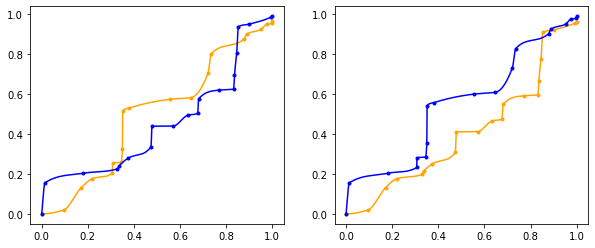

In [3449]:
#TEST crossover_curve_v2
Xs_childN_genes = 5
depth_grid = np.linspace(0,1,1000)
Xs = []
for i in range(2):
    depth = np.concatenate([np.random.rand(N_genes-2), np.array([0,1])])
    time = np.concatenate([np.random.rand(N_genes-1), np.array([0])])
    time.sort(); depth.sort()
    Xs = Xs + [np.vstack([depth,time])]
# Xs_child = crossover_curve_v2(*Xs)
Xs_child = crossover_curve_v3(*Xs)
fig, axs = plt.subplots(1,2, figsize=(10,4))
X_plot = Xs, Xs_child
colors = ["orange","blue"]
for j in range(2):
    for i in range(2):
        Xi = X_plot[j][i]
        spl = PchipInterpolator(Xi[0],Xi[1])
        axs[j].plot(depth_grid, spl(depth_grid),color=colors[i])
        axs[j].plot(Xi[0],Xi[1],".",color=colors[i])
#     axs[j].set_ylim([0,1])

In [2143]:
def mutation_curve(x1, pm, yrange=[0,1], xrange=[0,1]):
    """
    input: x1(2,n) is a gene
    pm is probability of mutaion
    cycle through each element of x1: for each iteration delete it (50%) or 
    randomly create a new element (50%) with a probability pm
    output: new x1
    """
    x1_m = x1.copy()
    n = len(x1[0])
    bool_m = np.random.rand(n) < pm ; bool_m[0]=False; bool_m[-1]=False;
    arg_m  = np.argwhere(bool_m)
    bool_del = np.random.rand(len(arg_m)) < 0.5
    arg_del = arg_m[bool_del]
    x1_m = np.delete(x1_m, arg_del, axis=1)
    
    # MUTATION AT BOUNDARY
#     if np.random.rand() < pm :
#         x1_m[1,0] = np.random.rand()*(x1_m[1,1]-yrange[0])+yrange[0]
    if np.random.rand() < pm :
        x1_m[1,-1] = np.random.rand()*(x1_m[1,-2]-yrange[1])+yrange[1]
    
    new_ele_x = np.random.rand(len(arg_m)-len(arg_del))
    new_ele_x = new_ele_x*(xrange[1] - xrange[0]) + xrange[0]
    new_ele_x.sort();
    ind_new = np.searchsorted(x1_m[0], new_ele_x)
    new_ele_y = np.random.rand(len(arg_m)-len(arg_del))
    new_ele_y = new_ele_y*(x1_m[1,ind_new]-x1_m[1,ind_new-1]) + x1_m[1,ind_new-1]
    new_ele_y.sort()
    new_ele = np.vstack([new_ele_x, new_ele_y])
    x1_m = np.insert(x1_m, ind_new, new_ele, axis=1)
       
    return x1_m


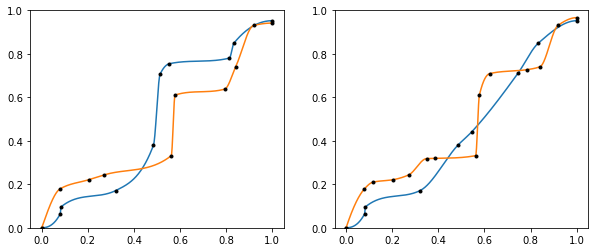

In [2150]:
#TEST mutation
N_genes = 10
depth_grid = np.linspace(0,1,1000)
m = 2
Xs = []
Xs_child = []
for i in range(m):
    depth = np.concatenate([np.random.rand(N_genes-2), np.array([0,1])])
    time = np.concatenate([np.random.rand(N_genes-1), np.array([0])])
    time.sort(); depth.sort()
    Xs = Xs + [np.vstack([depth,time])]
    Xs_child += [mutation_curve(Xs[i], 0.5, yrange=[0,1])]
fig, axs = plt.subplots(1,2, figsize=(10,4))
X_plot = Xs, Xs_child
# colors = ["orange","blue"]
for j in range(2):
    for i in range(m):
        Xi = X_plot[j][i]
        spl = PchipInterpolator(Xi[0],Xi[1])
        axs[j].plot(depth_grid, spl(depth_grid))
        axs[j].plot(Xi[0],Xi[1],".",color="black")
    axs[j].set_ylim([0,1])

### The procedure

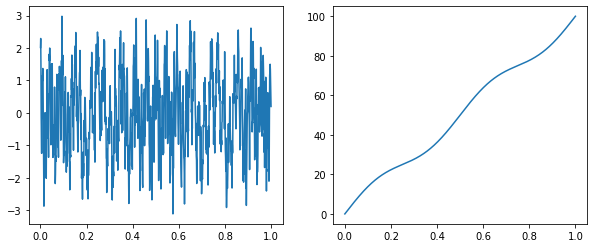

In [4048]:
N_data = 1000
depth_data = np.linspace(0, 1, N_data)
def depth_to_time_sin(depth):
    return depth_data*100 + np.sin(depth_data*2*np.pi*2)*4
def depth_to_time_parabol(depth, a=-50):
    #a: curvature of the function at point 0
    #a>0: concave; a<0:convex
    b = 100-a
    return depth_data**2*a +depth_data*b
depth_to_time = partial(depth_to_time_parabol, a=-80)
depth_to_time = depth_to_time_sin
t = depth_to_time(depth_data)
# t = depth_data*100
f1 = 1; f2= 4.3
A1 = 1; A2 = 1.2
# phi1 = 1; phi2=0.2
y = A1*np.cos(f1*t) + A2*np.cos(f2*t) 
eps = np.random.randn(N_data)
y_data = y + eps*0.5
fig, axs =plt.subplots(1,2, figsize=(10,4))
axs[0].plot(depth_data,y_data)
axs[1].plot(depth_data,t)

In [4049]:
K = 1000 # number of individual in population 
n_generations_max = 200
N_genes = 20 # number of intiial gene in an individial of the population 
# BICs_all = np.zeros((n_generations_max-1,K))
BICs_all = []
td_ini = []
for i in range(K):
    depth = np.concatenate([np.random.rand(N_genes-2), np.array([0,1])])
    time = np.concatenate([np.random.rand(N_genes-1), np.array([0])])
    time = time*100
    time.sort(); depth.sort()
#     time = depth*30
    td = np.vstack([depth,time])
    td_ini += [td]
td_all = []
td_all += [td_ini]

In [4050]:
eps = 1e-4
for i in range(n_generations_max-1):
#     print(i)
    tds_i = td_all[i]
    BICs_i = BIC_pop(tds_i, depth_data, y_data, [f1,f2])
    if BICs_i.min() ==  BICs_i.max():
        break
    BICs_all += [BICs_i]
#     BICs_all[i] = BICs_i
    selected_inds = selection_tournament(-BICs_i, K, 2)
    BICs_i = BICs_i[selected_inds]
    BICmean = BICs_i.mean(); BICmin = BICs_i.min()
    tds_new = []
    for j in range(0,K,2):
        BICm = np.min(BICs_i[j:j+2])
        pc = (BICm-BICmin)/(BICmean-BICmin + eps) if BICm <= BICmean else 1
        pc = min([pc,1])
        if np.random.rand() < pc:
            tds_new += crossover_curve_v2(tds_i[selected_inds[j]], tds_i[selected_inds[j+1]])
        else:
            tds_new += [tds_i[selected_inds[j]], tds_i[selected_inds[j+1]]]
    BICs_i = BIC_pop(tds_new, depth_data, y_data, [f1,f2])
    BICmean = BICs_i.mean(); BICmin = BICs_i.min()
    for j in range(K):
        pm = 0.5*(BICs_i[j]-BICmin)/(BICmean-BICmin + eps) if BICs_i[j] <= BICmean else 0.5
        pm = min([pm,1])
        tds_new[j] = mutation_curve(tds_new[j], pm, yrange=[0,100])
    shuffle(tds_new)
    td_all += [tds_new]

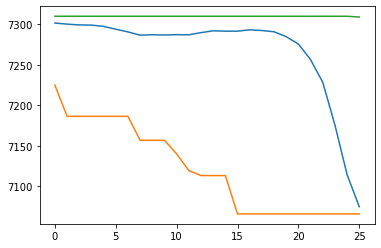

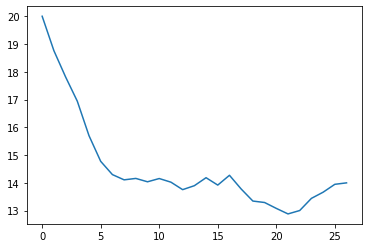

In [4051]:
n_generations = len(td_all)
BICs_all = np.array(BICs_all)
plt.figure()
plt.plot(BICs_all.mean(axis=1))
plt.plot(BICs_all.min(axis=1))
plt.plot(BICs_all.max(axis=1))
plt.figure()
len_td = np.array([[td_all[j][i].shape[1] for i in range(K) ] for j in range(n_generations)  ])
plt.plot(len_td.mean(axis=1))

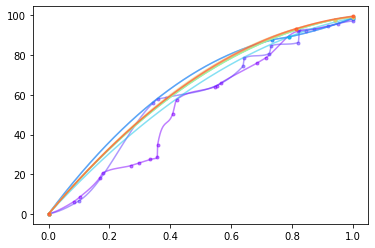

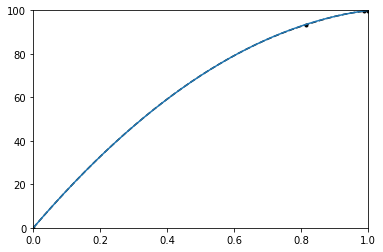

In [3474]:
%matplotlib inline
cm = plt.get_cmap("rainbow")
plt.figure()
arg_best = np.argmin(BICs_all, axis=1)
for i in range(0,n_generations-1,2):
    depth, time = td_all[i][arg_best[i]]
    spl2 = PchipInterpolator(depth, time)
    y2 = spl2(depth_data)
    plt.plot(depth_data, y2, depth, time, ".", color=cm(i/n_generations), alpha=0.5)

plt.figure()
depth, time = td_all[-1][0]
spl2 = PchipInterpolator(depth, time)
y2 = spl2(depth_data)
plt.plot(depth_data, y2, "--",depth, time, ".", color="black")
plt.ylim([0,100])
plt.xlim([0,1])
plt.plot(depth_data, depth_to_time(depth_data) ,'-')
# plt.ylim([0,100])
# plt.xlim([0,1])


(0.0, 200.0)

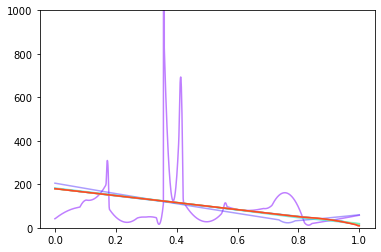

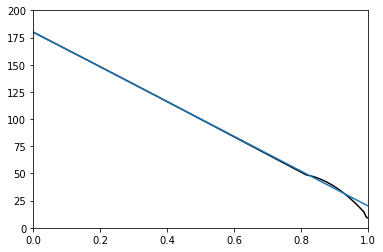

In [3477]:
%matplotlib inline
cm = plt.get_cmap("rainbow")
plt.figure()
arg_best = np.argmin(BICs_all, axis=1)
for i in range(0,n_generations-1,5):
    depth, time = td_all[i][arg_best[i]]
    spl2 = PchipInterpolator(depth, time)
    y2 = spl2(depth_data)
    y2p = np.gradient(y2, depth_data[1]-depth_data[0])
    plt.plot(depth_data,y2p, color=cm(i/n_generations), alpha=0.5)
plt.ylim([0,1000])
#     plt.plot(depth_data, y2, depth, time, ".", color=cm(i/n_generations), alpha=0.5)
plt.figure()
depth, time = td_all[-1][0]
spl2 = PchipInterpolator(depth, time)
y2 = spl2(depth_data)
y2p = np.gradient(y2, depth_data[1]-depth_data[0])
plt.plot(depth_data, y2p, color="black")
plt.ylim([0,1000])
plt.xlim([0,1])
y_real = depth_to_time(depth_data)
yp_real = np.gradient(y_real, depth_data[1]-depth_data[0])
plt.plot(depth_data, yp_real ,'-')
plt.ylim([0,200])


-0.16012867798353847 [-0.75887744  0.36165589] 0.03607994235442093


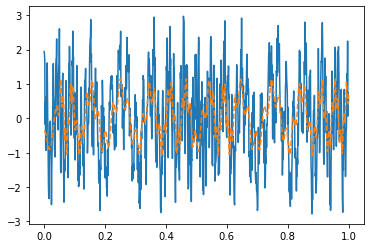

In [2818]:
%matplotlib inline
depth, time = td_all[-1][0]
spl2 = PchipInterpolator(depth, time)
t = spl2(depth_data)
# t = 100*d
x1 = np.cos(f1*t);
x2 = np.cos(f2*t)
Xmodel = np.vstack([x1,x2]).T
# X.shape
reg = LinearRegression().fit(Xmodel, y_data)
# reg.score(X, y_data), reg.coef_, reg.intercept_
plt.plot(d, y_data)
plt.plot(d, reg.predict(Xmodel), "--")
# plt.figure()
# plt.plot(d, y_data-reg.predict(Xmodel))
print(reg.score(X, y_data), reg.coef_, reg.intercept_)
# t = depth_data*100
# f1 = 1; f2=4
# A1 = 2; A2 = 1.

### Misc

<IPython.core.display.Javascript object>


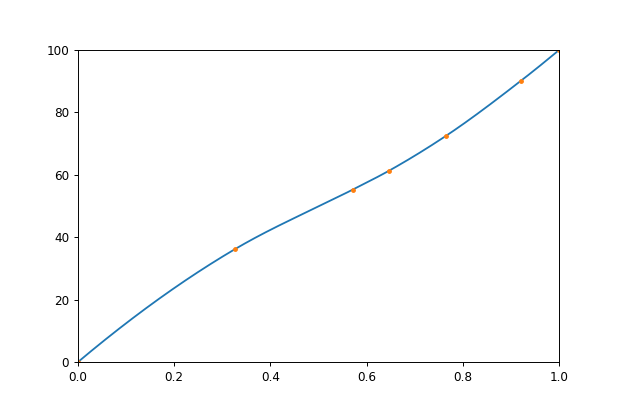

In [2452]:
import matplotlib.animation as animation
%matplotlib notebook


fig = plt.figure() # initialise la figure
line1, = plt.plot([], []) 
line2, = plt.plot([], [], ".") 
plt.xlim(0, 1)
plt.ylim(0, 100)
arg_best = np.argmin(BICs_all, axis=1)
def animate(i): 
    depth, time = td_all[i][arg_best[i]]
    spl2 = PchipInterpolator(depth, time)
    y2 = spl2(depth_data)
    line1.set_data(depth_data, y2)
    line2.set_data(depth, time)
    return line1
 
ani = animation.FuncAnimation(fig, animate, frames=100, blit=True, interval=20, repeat=False)

plt.show()

<IPython.core.display.Javascript object>


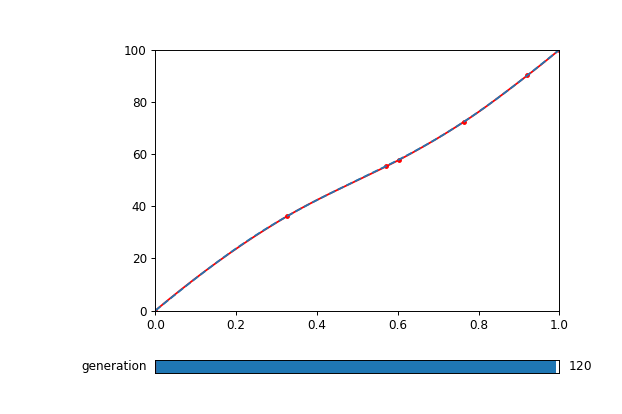

In [2479]:
%matplotlib notebook

fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.25)
plt.plot()
line1, = ax.plot([], [], color="red") 
line2, = ax.plot([], [], ".r") 
# ax.set_xlabel('Time [s]')
plt.xlim(0, 1)
plt.ylim(0, 100)
plt.plot(depth_data, depth_to_time(depth_data) ,'--')

axfreq = plt.axes([0.25, 0.1, 0.65, 0.03])
gen_slider = Slider(
    ax=axfreq,
    label='generation', valmin=1, valmax=len(td_all), 
    valinit=1,
    valstep=np.arange(len(td_all)),
)


def update(i):
    depth, time = td_all[i][arg_best[i]]
    spl2 = PchipInterpolator(depth, time)
    y2 = spl2(depth_data)
    line1.set_data(depth_data, y2)
    line2.set_data(depth, time)
    fig.canvas.draw_idle()
gen_slider.on_changed(update)
plt.show()

## TimeOpt v3

### Play Ground

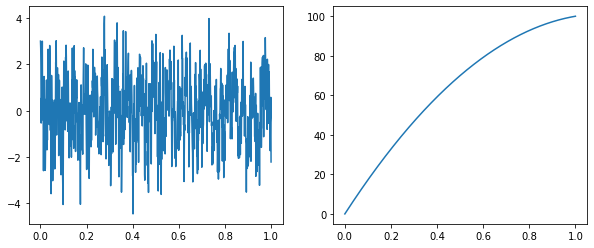

In [4064]:
N_data = 1000
depth_data = np.linspace(0, 1, N_data)
def depth_to_time_sin(depth):
    return depth_data*100 + np.sin(depth_data*2*np.pi*2)*4
def depth_to_time_parabol(depth, a=-50):
    #a: curvature of the function at point 0
    #a>0: concave; a<0:convex
    b = 100-a
    return depth_data**2*a +depth_data*b
depth_to_time = partial(depth_to_time_parabol, a=-80)
# depth_to_time = depth_to_time_sin
t = depth_to_time(depth_data)
# t = depth_data*100
f1 = 1; f2= 4.3
A1 = 1; A2 = 1.2
# phi1 = 1; phi2=0.2
y = A1*np.cos(f1*t) + A2*np.cos(f2*t) 
eps = np.random.randn(N_data)
y_data = y + eps*1
fig, axs =plt.subplots(1,2, figsize=(10,4))
axs[0].plot(depth_data,y_data)
axs[1].plot(depth_data,t)

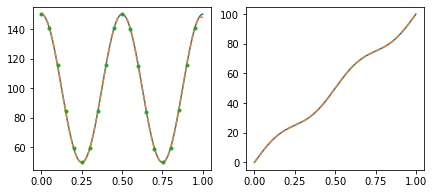

In [4054]:
%matplotlib inline
yp = np.gradient(t, depth_data[1]-depth_data[0])
points_sp = depth_data[::50], yp[::50]
spl_yp = splrep(*points_sp, s=0)
yp_x = splev(depth_data, spl_yp)
yx = sp.integrate.cumtrapz(yp_x, depth_data, initial=0)
fig, axs =plt.subplots(1,2,figsize=(7,3))
ax = axs[0]
ax.plot(depth_data, yp)
ax.plot(depth_data, yp_x, '--')
ax.plot(*points_sp,".")
ax = axs[1]
ax.plot(depth_data, t)
ax.plot(depth_data, yx, '--')

### Selection and metric

In [3665]:
def zero_function(x):
    return x*0

def metric(SR, data, fs, metric_type="BIC", k=3):
    """
    Input
    SR (2,n):  sedimetation rates and corresponding depth
    data (2,n): the data and corresponding depth
    fs: list of frequencies of the model
    metric_type: "BIC", "AIC" or "RSS"
    k=3: cubic spline
    td: time_depth function
    """
    depth, y_data = data
    spl_SR = splrep(*SR,k=k)
    f_SR = splev(depth, spl_SR)
    t = sp.integrate.cumtrapz(f_SR, depth, initial=0)
    Xmodel = np.concatenate([np.cos(np.array(fs)[None]*t[:,None]), np.sin(np.array(fs)[None]*t[:,None])], axis=1)
    reg_model = LinearRegression().fit(Xmodel, y_data)
    # Residual Sum Square
    RSS = np.sum((y_data - reg_model.predict(Xmodel))**2 )
    N = len(y_data)
    n_params_SR = len(SR[0])
    n_params = n_params_SR*2 + k+1 + len(fs)*2 + 2 
    if metric_type == "BIC":
        coef = np.log(N)
    elif metric_type == "AIC":
        coef = 2
    elif metric_type == "RSS":
        coef = 0
    metric = N*np.log(RSS) + coef*n_params
    return metric
    
def metric_pop(SRs, depth, data, fs, metric_type="BIC", k=3):
    return np.array([metric(SR, depth, data, fs, metric_type, k) for SR in SRs]) 
yp = np.gradient(t, depth_data[1]-depth_data[0])
metric([depth_data[::100], yp[::100]], [depth_data, y_data], [f1,f2])

7450.880533201474

### Crossover and Mutation

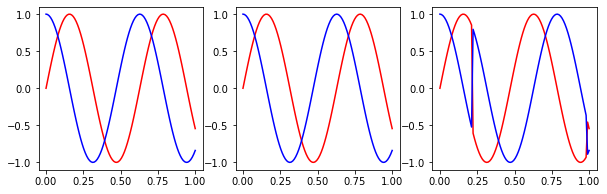

In [2983]:
def crossover_2points(x1, x2):
    """ 2-point crossover operation
    input: x1 (n,), x2 (n,) in ascending order
    define randomly an interval in the position of elements 
    swap all the array elements inside the interval of x1 with x2
    return (x1_x, x2_x)
    """
#     if interval is None:
#     interval = np.sort(np.random.rand(2))*(range_data[1]-range_data[0]) + range_data[0]          
#     arg_range1 = np.searchsorted(x1, interval)
#     arg_range2 = np.searchsorted(x2, interval)
    assert len(x1) == len(x2)
    arg_range = np.random.choice(range(len(x1)),2); arg_range.sort()
    x1_x = np.hstack([x1[:arg_range[0]], x2[arg_range[0]:arg_range[1]], x1[arg_range[1]:]] )
    x2_x = np.hstack([x2[:arg_range[0]], x1[arg_range[0]:arg_range[1]], x2[arg_range[1]:]] )
    return [x1_x, x2_x]

def crossover_2points_pop(X, metric_data):
    metric_m = np.min( np.vstack([metric_data[::2],metric_data[1::2]]),axis=0)
    metric_mean = metric_data.mean(); metric_min=metric_data.min()
    pc = np.ones(len(metric_m))
    eps =1e-5
    pc[metric_m<=metric_mean] = (metric_m[metric_m<=metric_mean]-metric_min)/(metric_mean-metric_min + eps) 
    Xx = X.copy()
    for i in range(len(pc)):
        if np.random.rand() < pc[i]:
            Xx[i*2:i*2+2] = np.array(crossover_2points(Xx[i*2],Xx[i*2+1]))
    return Xx

def crossover_2d(x1, x2, interval=None, range_data=[0,1]):
    """ 2-point crossover operation for 2d data
    input: x1 (2,n), x2 (2,m) in ascending order
    given / define randomly an interval in range_data 
    swap all the array elements inside the [interval] of x1 with x2
    return (x1_x, x2_x)
    """
    if interval is None:
        interval = np.sort(np.random.rand(2))*(range_data[1]-range_data[0]) + range_data[0]          
    arg_range1 = np.searchsorted(x1[0], interval)
    arg_range2 = np.searchsorted(x2[0], interval)
    x1_x = np.hstack([x1[:,:arg_range1[0]], x2[:,arg_range2[0]:arg_range2[1]], x1[:,arg_range1[1]:]] )
    x2_x = np.hstack([x2[:,:arg_range2[0]], x1[:,arg_range1[0]:arg_range1[1]], x2[:,arg_range2[1]:]] )
    return [x1_x, x2_x]



# TEST
# x = np.linspace(0,1,100)
# x1 = np.vstack([x,np.sin(10*x)])
# x2 = np.vstack([x,np.cos(10*x)])
# x1_x, x2_x = crossover_2d(x1,x2)
# fig, axs =plt.subplots(1,2,figsize=(7,3))
# axs[0].plot(x1[0],x1[1], "red")
# axs[0].plot(x2[0], x2[1], color="blue")
# axs[1].plot(x1_x[0],x1_x[1], "r--", x2_x[0], x2_x[1], "b--")

# TEST
x = np.linspace(0,1,100)
x1 = np.sin(10*x)
x2 = np.cos(10*x)
# x1_x, x2_x = crossover_2points(x1,x2)
# fig, axs =plt.subplots(1,2,figsize=(7,3))
# axs[0].plot(x,x1, "red")
# axs[0].plot(x,x2, "b")
# axs[1].plot(x,x1_x, "red")
# axs[1].plot(x,x2_x, "b")
# axs[1].plot(x1_x[0],x1_x[1], "r--", x2_x[0], x2_x[1], "b--")

X = np.vstack([x1,x2,x1,x2])
x1_x, x2_x, x1_xx, x2_xx =crossover_2points_pop(X,np.array([1,8,6,7]))
fig, axs =plt.subplots(1,3,figsize=(10,3))
axs[0].plot(x,x1, "red")
axs[0].plot(x,x2, "b")
axs[1].plot(x,x1_x, "red")
axs[1].plot(x,x2_x, "b")
axs[2].plot(x,x1_xx, "red")
axs[2].plot(x,x2_xx, "b")

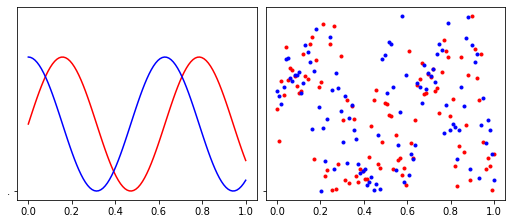

In [3183]:
def crossover_blend(x1, x2, alpha=0.5):
    """ 2-point crossover operation
    input: x1 (n,), x2 (n,) in ascending order
    define randomly an interval in the position of elements 
    swap all the array elements inside the interval of x1 with x2
    return (x1_x, x2_x)
    """
    assert len(x1) == len(x2)
    x12 = np.vstack([x1,x2])
    min_x12 = np.min(x12,axis=0)
    max_x12 = np.max(x12,axis=0)
    range_x12 = max_x12-min_x12
    min_range = np.max([min_x12-range_x12*alpha , np.zeros(len(x1))],axis=0)
    x1_x = np.random.rand(len(x1))*range_x12*(1+2*alpha) + min_range
    x2_x = np.random.rand(len(x1))*range_x12*(1+2*alpha) + min_range
    return [x1_x, x2_x]

def crossover_blend_pop(X, metric_data):
    metric_m = np.min( np.vstack([metric_data[::2],metric_data[1::2]]),axis=0)
    metric_mean = metric_data.mean(); metric_min=metric_data.min()
    pc = np.ones(len(metric_m))
    eps =1e-5
    pc[metric_m<=metric_mean] = (metric_m[metric_m<=metric_mean]-metric_min)/(metric_mean-metric_min + eps) 
    Xx = X.copy()
    for i in range(len(pc)):
        if np.random.rand() < pc[i]:
            Xx[i*2:i*2+2] = np.array(crossover_blend(Xx[i*2],Xx[i*2+1]))
    return Xx
# TEST crossover_blended
x = np.linspace(0,1,100)
x1 = np.sin(10*x)+1
x2 = np.cos(10*x)+1
x1_x, x2_x = crossover_blend(x1,x2,0.5)
fig, axs =plt.subplots(1,2,figsize=(7,3),sharey=True,constrained_layout=True)
axs[0].plot(x,x1, "red")
axs[0].plot(x,x2, "b")
axs[1].plot(x,x1_x, ".r",'.')
axs[1].plot(x,x2_x, ".b",'.')
# axs[1].plot(x1_x[0],x1_x[1], "r--", x2_x[0], x2_x[1], "b--")

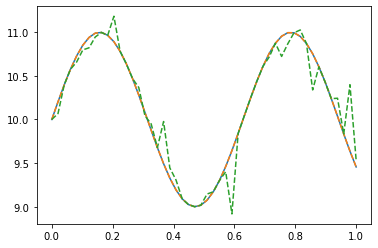

In [3007]:
def mutation(x1, pm, xrange=[0,1], yrange=[0,1]):
    """
    input: x1(2,n) is a gene
    pm is probability of mutaion
    cycle through each element of x1: for each iteration delete it (50%) or 
    randomly create a new element (50%) with a probability pm
    output: new x1
    """
    x1_m = x1.copy()
    n = len(x1[0])
    bool_m = np.random.rand(n) < pm
    arg_m  = np.argwhere(bool_m)[:,0]
    bool_del = np.random.rand(len(arg_m)) < 0.5
    arg_del = arg_m[bool_del]
    new_ele = np.random.rand(2,len(arg_m)-len(arg_del))
    new_ele[0] = new_ele[0]*(xrange[1] - xrange[0]) + xrange[0]
    new_ele[1] = new_ele[1]*(yrange[1] - yrange[0]) + yrange[0]
    x1_m = np.delete(x1_m, arg_del, axis=1)
    x1_m = np.hstack([x1_m, new_ele])
    x1_m = x1_m[:,np.argsort(x1_m[0])]
    return x1_m
def mutation_poly(x1, pm, xrange=[0,1], eta=50):
    """
    Polynomial Mutation (Deb and Deb 2014)
    input: x1(n, ) is a gene
    pm is probability of mutaion
    output: new x1
    """
    x1_m = x1.copy()
    n = len(x1)
    bool_m = np.random.rand(n) < pm
    arg_m  = np.argwhere(bool_m)[:,0]
    u = np.random.rand(len(arg_m))
    arg_m_L = arg_m[u<=0.5]
    arg_m_R = arg_m[u>0.5]
    delta_L = (2*u[u<=0.5])**(1/(1+eta))-1
    delta_R = 1-(2*(1-u[u>0.5]))**(1/(1+eta))
    x1_m[arg_m_L] = x1_m[arg_m_L] + delta_L*(x1_m[arg_m_L] - xrange[0])
    x1_m[arg_m_R] = x1_m[arg_m_R] + delta_R*(-x1_m[arg_m_R] + xrange[1])
    return x1_m

def mutation_poly_pop(X, metric_X, xrange=[0,1], eta=50):
    metric_mean = metric_X.mean(); metric_min=metric_X.min()
    pm = np.ones(len(metric_X))*0.5
    eps=1e-5
    pm[metric_X<=metric_mean] = (metric_X[metric_X<=metric_mean]-metric_min)/(metric_mean-metric_min + eps) 
#     print(pm)
    Xm = np.array([mutation_poly(X[i], pm[i], xrange, eta) for i in range(len(X))])
    return Xm


#TEST 1
# x = np.linspace(0,1,50)
# x1 = np.vstack([x,np.sin(10*x)])
# x1_x = mutation(x1, 0.5, yrange=[-1,1])
# plt.plot(x1[0],x1[1])
# plt.plot(x1_x[0],x1_x[1],'.')


# TEST mutation_poly
# x = np.linspace(0,1,50)
# x1 = np.sin(10*x)+10
# x1_x = mutation_poly(x1, 0.5, xrange=[0,20], eta=50)
# plt.plot(x, x1)
# plt.plot(x,x1_x)
# plt.plot(x, x1-x1_x)
# plt.plot(x1_x[0],x1_x[1])

#TEST mutation_poly_pop
x = np.linspace(0,1,50)
x1 = np.sin(10*x)+10
X = np.vstack([x1,x1,x1,x1])
X_x = mutation_poly_pop(X, np.array([0,1,1,1]), xrange=[0,20], eta=50)
# fig, axs = plt.figure(1,3)
plt.plot(x, x1)
plt.plot(x, X_x[0],'--')
plt.plot(x, X_x[1],'--')

### The Procedure

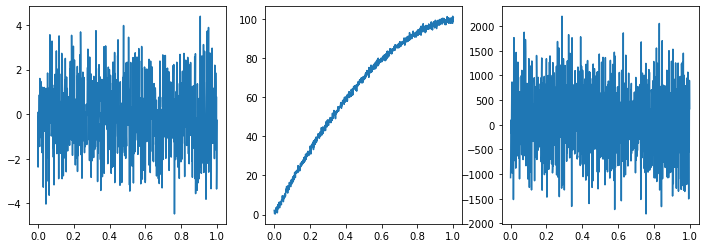

In [4121]:
N_data = 1000
depth_data = np.linspace(0, 1, N_data)
def depth_to_time_sin(depth):
    return depth_data*100 + np.sin(depth_data*2*np.pi)*4
def depth_to_time_parabol(depth, a=-50):
    #a: curvature of the function at point 0
    #a>0: concave; a<0:convex
    b = 100-a
    return depth_data**2*a +depth_data*b
def depth_to_time_cubic(depth, a=-50, c=1):
    #a: curvature of the function at point 0
    #a>0: concave; a<0:convex
    b = 100-a
    return depth_data**2*a +depth_data*b + depth_data**3*c

def depth_to_time_parabol_noise(depth, a=-50, sigma=1):
    #a: curvature of the function at point 0
    #a>0: concave; a<0:convex
    b = 100-a
    noise = np.random.randn(len(depth_data))*sigma
    return depth_data**2*a +depth_data*b + noise 

def depth_to_time_constant(depth):
    return depth*100
depth_to_time = partial(depth_to_time_parabol, a=-80)
depth_to_time = partial(depth_to_time_cubic, a=-80, c=0)
depth_to_time = partial(depth_to_time_parabol_noise, a=-80, sigma=1)
# depth_to_time = depth_to_time_constant
time_data = depth_to_time(depth_data)
# t = depth_data*100
f1 = 1; f2= 4.3
A1 = 1; A2 = 1.2
# phi1 = 1; phi2=0.2
y = A1*np.cos(f1*time_data) + A2*np.cos(f2*time_data) 
eps = np.random.randn(N_data)
y_data = y + eps*1
fig, axs =plt.subplots(1,3, figsize=(12,4))
axs[0].plot(depth_data,y_data)
axs[1].plot(depth_data,time_data)
axs[2].plot(depth_data,np.gradient(time_data, depth_data[1]-depth_data[0]))

In [4122]:
K = 1000 # number of individual in population 
n_generations_max = 200
N_genes = 5 # number of intial gene in an individial of the population 
depth_grid = np.linspace(0,1,N_genes)
SR_lims = [0, 200]
# BICs_all = np.zeros((n_generations_max-1,K))
metric_all = np.zeros((n_generations_max,K))
SR_all = np.zeros((n_generations_max,K,N_genes))
SR_ini = np.random.rand(K,N_genes)*SR_lims[1]
SR_all[0] = SR_ini
metric_ini = np.array([metric([depth_grid, SR_ini_i] , [depth_data, y_data], [f1, f2], metric_type="BIC", k=3) for SR_ini_i in SR_ini])
metric_all[0] = metric_ini

7467.35094921448

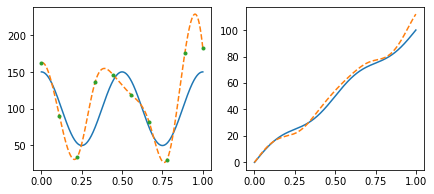

In [3562]:
%matplotlib inline
yp = np.gradient(time_data, depth_data[1]-depth_data[0])
i=15
points_sp = depth_grid, SR_ini[i]
spl_yp = splrep(*points_sp, s=0)
yp_x = splev(depth_data, spl_yp)
yx = sp.integrate.cumtrapz(yp_x, depth_data, initial=0)
fig, axs =plt.subplots(1,2,figsize=(7,3))
ax = axs[0]
ax.plot(depth_data, yp)
ax.plot(depth_data, yp_x, '--')
ax.plot(*points_sp,".")
ax = axs[1]
ax.plot(depth_data, time_data)
ax.plot(depth_data, yx, '--')
metric([depth_grid, SR_ini[i]] , [depth_data, y_data], [f1, f2], metric_type="BIC", k=3)


In [4123]:
eps = 1e-4
for i in range(n_generations_max-1):
#     print(i)
    SR_i = SR_all[i]
    metric_i = metric_all[i]
    if metric_i.min() ==  metric_i.max():
        n_generations = i+1
        break
    selected_inds = selection_tournament(-metric_i, K, 2, elitism=True)
    SR_ip = crossover_blend_pop(SR_i[selected_inds], metric_i[selected_inds])
    metric_ip = np.array([metric([depth_grid, SR_i_j] , [depth_data, y_data], [f1, f2], metric_type="BIC", k=3) for SR_i_j in SR_ip])
    SR_ip = mutation_poly_pop(SR_ip, metric_ip, xrange=[0,20], eta=20)
    metric_ip = np.array([metric([depth_grid, SR_i_j] , [depth_data, y_data], [f1, f2], metric_type="BIC", k=3) for SR_i_j in SR_ip])
    metric_all[i+1] = metric_ip
    SR_all[i+1] = SR_ip
print(n_generations)
metric_all = metric_all[:n_generations]
SR_all = SR_all[:n_generations]

106


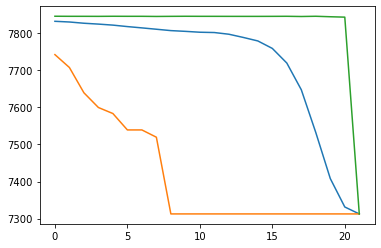

In [4117]:
plt.figure()
plt.plot(metric_all.mean(axis=1))
plt.plot(metric_all.min(axis=1))
plt.plot(metric_all.max(axis=1))

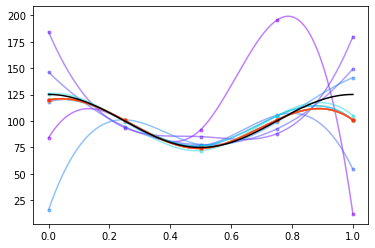

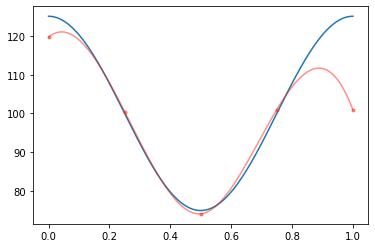

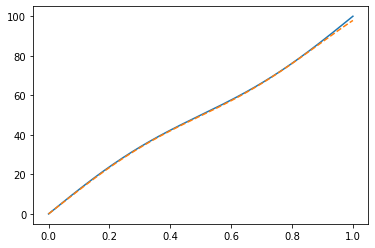

In [4119]:
%matplotlib inline
cm = plt.get_cmap("rainbow")
plt.figure()
arg_best = np.argmin(metric_all, axis=1)
for i in range(0,n_generations,1):
    SR_best = SR_all[i,arg_best[i]]
    spl_SR = splrep(depth_grid, SR_best, s=0)
    SR_smooth = splev(depth_data, spl_SR)
    
    plt.plot(depth_data, SR_smooth, depth_grid, SR_best, ".", color=cm(i/n_generations), alpha=0.5)

t_data = depth_to_time(depth_data)
plt.plot(depth_data, np.gradient(t_data, depth_data[1]-depth_data[0]), color="black")
plt.figure()
t_data = depth_to_time(depth_data)
plt.plot(depth_data, np.gradient(t_data, depth_data[1]-depth_data[0]))
SR_best = SR_all[-1,arg_best[-1]]
spl_SR = splrep(depth_grid, SR_best, s=0)
SR_smooth = splev(depth_data, spl_SR)

plt.plot(depth_data, SR_smooth, depth_grid, SR_best, ".", color=cm(i/n_generations), alpha=0.5)



# %matplotlib inline
i=-1
SR_best = SR_all[i,arg_best[i]]
spl_SR = splrep(depth_grid, SR_best, s=0)
SR_smooth = splev(depth_data, spl_SR)
yx = sp.integrate.cumtrapz(SR_smooth, depth_data, initial=0)
fig, ax =plt.subplots(1,1)
# ax = axs[0]
ax.plot(depth_data, time_data)
ax.plot(depth_data, yx, '--')
# ax.plot(*points_sp,".")



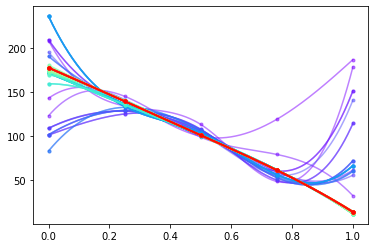

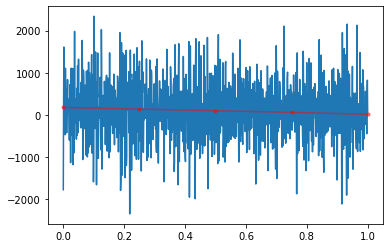

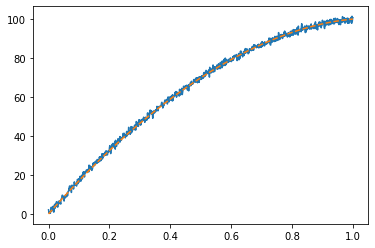

In [4129]:
%matplotlib inline
cm = plt.get_cmap("rainbow")
plt.figure()
arg_best = np.argmin(metric_all, axis=1)
for i in range(0,n_generations,1):
    SR_best = SR_all[i,arg_best[i]]
    spl_SR = splrep(depth_grid, SR_best, s=0)
    SR_smooth = splev(depth_data, spl_SR)
    
    plt.plot(depth_data, SR_smooth, depth_grid, SR_best, ".", color=cm(i/n_generations), alpha=0.5)

# t_data = depth_to_time(depth_data)
# plt.plot(depth_data, np.gradient(t_data, depth_data[1]-depth_data[0]), color="black")
plt.figure()
t_data = depth_to_time(depth_data)
plt.plot(depth_data, np.gradient(t_data, depth_data[1]-depth_data[0]))
SR_best = SR_all[-1,arg_best[-1]]
spl_SR = splrep(depth_grid, SR_best, s=0)
SR_smooth = splev(depth_data, spl_SR)

plt.plot(depth_data, SR_smooth, depth_grid, SR_best, ".", color=cm(i/n_generations), alpha=0.5)



# %matplotlib inline
i=-1
SR_best = SR_all[i,arg_best[i]]
spl_SR = splrep(depth_grid, SR_best, s=0)
SR_smooth = splev(depth_data, spl_SR)
yx = sp.integrate.cumtrapz(SR_smooth, depth_data, initial=0)
fig, ax =plt.subplots(1,1)
# ax = axs[0]
ax.plot(depth_data, time_data)
ax.plot(depth_data, yx, '--')
# ax.plot(*points_sp,".")



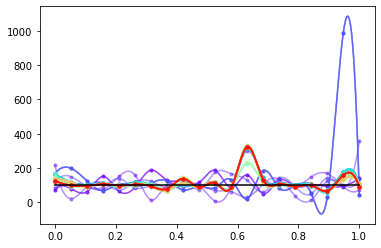

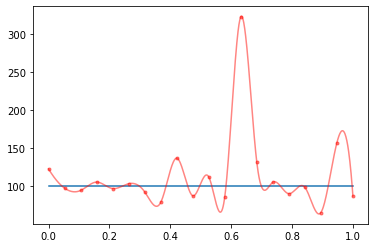

In [4063]:
%matplotlib inline
cm = plt.get_cmap("rainbow")
plt.figure()
arg_best = np.argmin(metric_all, axis=1)
for i in range(0,n_generations,1):
    SR_best = SR_all[i,arg_best[i]]
    spl_SR = splrep(depth_grid, SR_best, s=0)
    SR_smooth = splev(depth_data, spl_SR)
    
    plt.plot(depth_data, SR_smooth, depth_grid, SR_best, ".", color=cm(i/n_generations), alpha=0.5)

t_data = depth_to_time(depth_data)
plt.plot(depth_data, np.gradient(t_data, depth_data[1]-depth_data[0]), color="black")
plt.figure()
t_data = depth_to_time(depth_data)
plt.plot(depth_data, np.gradient(t_data, depth_data[1]-depth_data[0]))
SR_best = SR_all[-1,arg_best[-1]]
spl_SR = splrep(depth_grid, SR_best, s=0)
SR_smooth = splev(depth_data, spl_SR)

plt.plot(depth_data, SR_smooth, depth_grid, SR_best, ".", color=cm(i/n_generations), alpha=0.5)




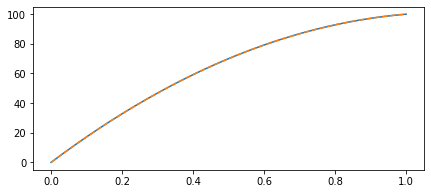

In [3575]:
%matplotlib inline
i=-1
SR_best = SR_all[i,arg_best[i]]
spl_SR = splrep(depth_grid, SR_best, s=0)
SR_smooth = splev(depth_data, spl_SR)
yx = sp.integrate.cumtrapz(SR_smooth, depth_data, initial=0)
fig, ax =plt.subplots(1,1,figsize=(7,3))
# ax = axs[0]
ax.plot(depth_data, time_data)
ax.plot(depth_data, yx, '--')
# ax.plot(*points_sp,".")


## eTimeOpt

In [3774]:
def RCGA_TimeOpt(data, fs, n_generations_max, SR_lims=[0,200], data_SR_ini=None, N_population=100, N_genes=5, k=3):
    """
    Apply the real-coded genetics algorithm to get the sedimentation rates (SR) from the data
    Input
    data[2,n]: depth[n], data[n]
    fs: f1, f1: 2 frequencies
    n_generations_max: number of generations
    SR_lims: limits of the SR
    data_SR_ini=  depth_grid[N_genes], SR_ini [N_population, N_genes]  : initial population of sedimentation rates
    N_genes [int]:  only used if data_SR_ini is not given, data_SR_ini = random(N_genes) * SR_lims for N_population 
    N_population: number of individual in population
    k: order of the spline, k=3: cubic spline
    Output
    SR_all: [n_generations, N_population, N_genes]: generations of populations of SR
    metric_all [n_generations,N_population]: metric of SR_all
    """
        
    depth_data, y_data = data 
    f1, f1 = fs
    n_generations = n_generations_max
#     K = 1000 # number of individual in population 
#     n_generations_max = 200
#     N_genes = 20 # number of intial gene in an individial of the population 
#     SR_lims = [0, 200]
    depth_range = [depth_data.min(),depth_data.max()]
    if data_SR_ini is None:   
        depth_grid = np.linspace(*depth_range,N_genes)
        SR_ini = np.random.rand(N_population,N_genes)*SR_lims[1]
    else: 
        depth_grid, SR_ini = data_SR_ini
        N_genes = len(depth_grid)
        N_population = SR_ini.shape[0]
    SR_all = np.zeros((n_generations_max,N_population,N_genes))
    SR_all[0] = SR_ini
    metric_all = np.zeros((n_generations_max,N_population))
    metric_ini = np.array([metric([depth_grid, SR_ini_i] , [depth_data, y_data], [f1, f2], metric_type="BIC", k=k) for SR_ini_i in SR_ini])
    metric_all[0] = metric_ini
    eps = 1e-4
    for i in range(n_generations_max-1):
        SR_i = SR_all[i]
        metric_i = metric_all[i]
        if metric_i.min() ==  metric_i.max():
            n_generations = i+1
            break
        selected_inds = selection_tournament(-metric_i, N_population, 2, elitism=True)
        SR_ip = crossover_blend_pop(SR_i[selected_inds], metric_i[selected_inds])
        metric_ip = np.array([metric([depth_grid, SR_i_j] , [depth_data, y_data], [f1, f2], metric_type="BIC", k=k) for SR_i_j in SR_ip])
        SR_ip = mutation_poly_pop(SR_ip, metric_ip, xrange=[0,20], eta=20)
        metric_ip = np.array([metric([depth_grid, SR_i_j] , [depth_data, y_data], [f1, f2], metric_type="BIC", k=k) for SR_i_j in SR_ip])
        metric_all[i+1] = metric_ip
        SR_all[i+1] = SR_ip
    print(str(n_generations) + " generations")
    metric_all = metric_all[:n_generations]
    SR_all = SR_all[:n_generations]
    return SR_all, depth_grid, metric_all

i_u=200
i_i=0
# SR_all, depth_grid, metric_all = RCGA_TimeOpt([depth_data[i_i:i_u], y_data[i_i:i_u]], [f1,f2], n_generations_max=100, SR_lims=[0,200], N_population=200, N_genes=4,k=3)
SR_all, depth_grid, metric_all = RCGA_TimeOpt([depth_data[i_i:i_u], y_data[i_i:i_u]], [f1,f2], n_generations_max, SR_lims, [depth_grid[:5], SR_ini[:,:5]])

40 generations


(0.0, 100.0)

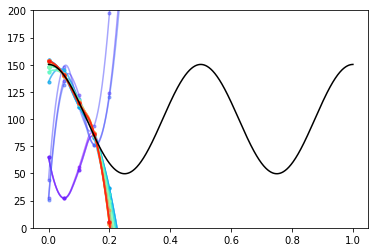

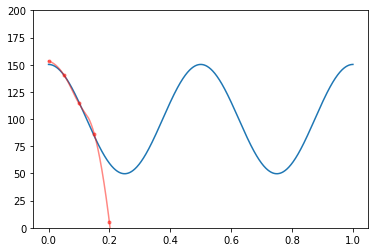

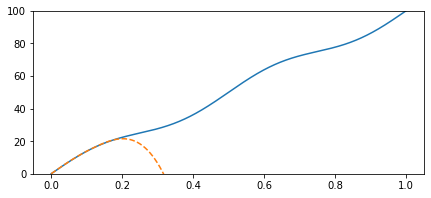

In [3769]:
%matplotlib inline
# %matplotlib notebook
cm = plt.get_cmap("rainbow")
arg_best = np.argmin(metric_all, axis=1)
n_generations = SR_all.shape[0]
k=2
plt.figure()
for i in range(0,n_generations,1):
    SR_best = SR_all[i,arg_best[i]]
    spl_SR = splrep(depth_grid, SR_best, s=0,k=k)
    SR_smooth = splev(depth_data, spl_SR)
    
    plt.plot(depth_data, SR_smooth, depth_grid, SR_best, ".", color=cm(i/n_generations), alpha=0.5)

t_data = depth_to_time(depth_data)
plt.plot(depth_data, np.gradient(t_data, depth_data[1]-depth_data[0]), color="black")
plt.ylim([0,200])
plt.figure()
t_data = depth_to_time(depth_data)
plt.plot(depth_data, np.gradient(t_data, depth_data[1]-depth_data[0]))
SR_best = SR_all[-1,arg_best[-1]]
spl_SR = splrep(depth_grid, SR_best, s=0,k=k)
SR_smooth = splev(depth_data, spl_SR)

plt.plot(depth_data, SR_smooth, depth_grid, SR_best, ".", color=cm(i/n_generations), alpha=0.5)
plt.ylim([0,200])


i=-1
SR_best = SR_all[i,arg_best[i]]
spl_SR = splrep(depth_grid, SR_best, s=0,k=k)
SR_smooth = splev(depth_data, spl_SR)
yx = sp.integrate.cumtrapz(SR_smooth, depth_data, initial=0)
fig, ax =plt.subplots(1,1,figsize=(7,3))
# ax = axs[0]
ax.plot(depth_data, time_data)
ax.plot(depth_data, yx, '--')
ax.set_ylim([0,100])

In [3636]:
# # NHUNG EM AH, EM AH,PHO XA DONG VUi, KHI CON EM CHO
# # KHI CON BAO NOI NHO, THUONG, THUONG, THUONG
# # NHUNG EM AH
# # EM AH
# AH AH ah ah
# GIET MOI CON DAU BANG NIEM VO VONG, BANG VAI TIA HY VONG, HY VONG CUA HAI TA
# NHUNG EM AH, EM AH
# 

In [4039]:
K = 1000 # number of individual in population 
n_generations_max = 40
N_genes = 21 # number of intial gene in an individial of the population 
depth_grid = np.linspace(0,1,N_genes)
SR_lims = [0, 200]
# BICs_all = np.zeros((n_generations_max-1,K))
metric_all = np.zeros((n_generations_max,K))
SR_all = np.zeros((n_generations_max,K,N_genes))
SR_ini = np.random.rand(K,N_genes)*SR_lims[1]
SR_all[0] = SR_ini
# metric_ini = np.array([metric([depth_grid, SR_ini_i] , [depth_data, y_data], [f1, f2], metric_type="BIC", k=3) for SR_ini_i in SR_ini])
# metric_all[0] = metric_ini

In [4042]:
window_width = 0.2
sliding_step = 0.2
depth_range = [0,1.0]
N_step = (max(depth_range) - window_width )/sliding_step + 1
N_step = round(N_step)
for i in range(N_step):
    window_range = sliding_step*i, sliding_step*i+window_width+1e-9
    print(window_range)
    i_i, i_u = np.searchsorted(depth_grid, window_range)
    data_SR_ini = depth_grid[i_i:i_u], SR_ini[:,i_i:i_u]
    i_i_d, i_u_d = np.searchsorted(depth_data, window_range)
    data = [depth_data[i_i_d:i_u_d], y_data[i_i_d:i_u_d]]
    SR_x, depth_gridx, metric_x = RCGA_TimeOpt(data, [f1,f2], n_generations_max, SR_lims, data_SR_ini)
    n_gen = SR_x.shape[0]
    SR_all[:n_gen,:,i_i:i_u] = SR_x; SR_all[-1,:,i_i:i_u]=SR_x[-1]
#     break

(0.0, 0.200000001)
40 generations
(0.2, 0.40000000100000005)
40 generations
(0.4, 0.6000000010000001)
19 generations
(0.6000000000000001, 0.800000001)
40 generations
(0.8, 1.000000001)
40 generations


(0.0, 200.0)

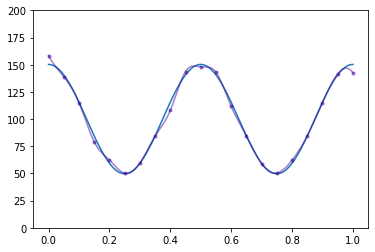

In [4044]:
plt.figure()
t_data = depth_to_time(depth_data)
plt.plot(depth_data, np.gradient(t_data, depth_data[1]-depth_data[0]))
SR_best = SR_all[-1,0]
# SR_best = SR_x[8,0]

spl_SR = splrep(depth_grid, SR_best, s=0,k=3)
SR_smooth = splev(depth_data, spl_SR)

plt.plot(depth_data, SR_smooth, depth_grid, SR_best, ".", color=cm(i/n_generations), alpha=0.5)
plt.ylim([0,200])

In [ ]:
asda s